# Key Findings

1. PM_not2020 (N = 10) and SPMI_not2020 (N = 16) has a relationship with Q8_segment2 (with KMeans)
2. Although their overall satisfaction is the same as the other group, they have highly spreaded Q8Q9 graph
3. Both groups rate all 3 recruiting items low satisfaction and high importance
4. In terms of solutions, they like recruiting process checklist and videos by 2nd-year students on jobs

Next step:
1. Need to incease the sample size to validate our current finding. N = 10 and 16 are rather small

# Backend (please ignore)

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from factor_analyzer import FactorAnalyzer
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import pyreadstat
import researchpy as rp

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
def paired_ttest_1d(df, pairs, alpha= 0.05, violinplot= True):
    # 1. Returns the results of paired t_tests for the 2 dependent samples (mean) for multiple pairs of variables
    # 2. Returns a violin plot at the end to illustrate the difference of samples for each pair of variables    
    #
    # Parameter pairs (dataframe): contains column names (str) of the dependent variables in df to be tested
    # Precondition: pairs contains only 2 columns: 'before' and 'after'; 
    #               for each index, pair.before and pair.after are the names of each pair of dependent variables
    
    for c in range(0, len(pairs.before)):
        before= pairs.iloc[c].before
        after= pairs.iloc[c].after
        paired_ttest_helper(df, before, after, alpha= alpha, violinplot= violinplot)
        #if c < len(pairs.before)-1:
        #    print('\n')

In [3]:
def paired_ttest_helper(df, before, after, alpha= 0.05, violinplot= True): 
    # Returns the results of paired t_tests for the two dependent samples (mean of variable)
    #
    # Precondition: before (str) and after (str) are column names in df (dataframe) and have the same shape
    # Precondition: alpha (float) > 0 and < 1; default = 0.05

    t_stat, p_value= stats.ttest_rel(df[before], df[after])
    
    # Print results
    if p_value > alpha:
        print('%s vs. %s (N = %i): no difference (fail to reject H0)' % (before, after, df[before].count()))
    else:
        print('%s vs. %s (N = %i): the difference is statistically significant (reject H0)' % (before, after, df[before].count()))
                    
    print('mean of %s: %.3f' % (before, df[before].mean()))             
    print('mean of %s: %.3f' % (after, df[after].mean()))    
    print('p-value of the difference: %.3f' % p_value)
    
    # Plot the graphs
    if violinplot is True:
        data = df.melt(value_vars= [before, after])      
        plt.subplot()
        sns.violinplot(x= 'variable', y= 'value', data= data)
        plt.show()
    if violinplot is False:
        data = df.melt(value_vars= [before, after])      
        plt.subplot()
        sns.boxplot(x= 'variable', y= 'value', data= data)
        plt.show()
    if violinplot is None:
        print('\n')

In [4]:
def multi_ttest_2d(df, segment, array_variable, alpha= 0.05, violinplot= True):
    for c in range(0, len(array_variable)):
        multi_ttest_1d(df, segment, array_variable[c], alpha= alpha, violinplot= violinplot)

In [5]:
def multi_ttest_1d(df, segment, variable, alpha= 0.05, violinplot= True):
    # 1. Returns the results of t_tests for the independent samples (mean): 
    #    segment is the independent (grouping) variable and variable contains dependent (test) variables
    # 2. Returns a violin plot at the end to illustrate the difference of samples in each segment
    #
    # Parameter df: the dataframe to be analyzed
    # Precondition: df is a dataframe
    #
    # Parameter segment: a column name (string) of segments from df
    # Precondition: segment is in df; segment is non-metric; data in segment starts from 0 and contains only integers;
    #               the maximum value of segment > 0 (i.e., there are more than 1 segments in df)
    #
    # Parameter variable: a column name (string) of test variable from df
    # Precondition: variable is in df; variable is metric
    #
    # Parameter alpha: decision rule to reject the null hypothesis (default= 0.05)
    # Precondition: alpha is a float > 0 and < 1
    #
    # Parameter violinplot: a boolean indicating whether the function return a violinplot. 
    #                       If violinplot is False, the function returns a boxplot
    # Precondition: violinplot is a boolean, default= True

    seg_min= df[segment].min()
    seg_max= df[segment].max()
    
    for a in range(seg_min, seg_max):
        for b in range(a+1, seg_max+1):
            ttest_helper(df, segment, a, b, variable, alpha)
            if (a < seg_max-1) or (b < seg_max):
                print('\n')

    if violinplot is True:
        plt.subplot()
        sns.violinplot(x= segment, y= variable, data= df)
        plt.show()
    if violinplot is False:
        plt.subplot()
        sns.boxplot(x= segment, y= variable, data= df)
        plt.show()

In [6]:
def ttest_helper(df, segment, a, b, variable, alpha= 0.05): 
    # Returns the results of t_tests for the independent samples (mean of variable) 
    # between segment == a and segment == b
    #
    # Parameter df: the dataframe to be analyzed
    # Precondition: df is a dataframe
    #
    # Parameter segment: a column name (string) of segments from df
    # Precondition: segment is in df; segment is non-metric; data in segment starts from 0 and contains only integers;
    #               the maximum value of segment > 0 (i.e., there are more than 1 segments in df)
    #
    # Parameter a: an integer in segment
    # Precondition: a != b
    #
    # Parameter b: an integer in segment
    # Precondition: b != a
    #
    # Parameter variable: a column name (string) of test variable from df
    # Precondition: variable is in df; variable is metric
    #
    # Parameter alpha: decision rule to reject the null hypothesis (default = 0.05)
    # Precondition: alpha is a float > 0 and < 1
    
    seg_a= df[variable].loc[df[segment] == a]
    seg_b= df[variable].loc[df[segment] == b]
    t_stat, p_value= stats.ttest_ind(seg_a, seg_b)
        
    if p_value > alpha:
        print('In %s, segments %i vs. %i: no difference (fail to reject H0)' % (variable, a, b))
    else:
        print('In %s, segments %i vs. %i: the difference is statistically significant (reject H0)' % (variable, a, b))
                    
    print('mean of %s when (%s = %i): %.3f, N: %i' % (variable, segment, a, seg_a.mean(), seg_a.count()))             
    print('mean of %s when (%s = %i): %.3f, N: %i' % (variable, segment, b, seg_b.mean(), seg_b.count()))    
    print('p-value of the difference: %.3f' % p_value)

In [7]:
def fa_adequacy_test(df):
    # 1. Return a boolean and a detail (str or int), indicating whether the dataframe df is adequate for factor analysis, 
    #    using Bartlett’s Test (with alpha <= 0.05) and Kaiser-Meyer-Olkin test (with KMO > 0.6), 
    #    i.e. "Can we find factors from the observed variables (the columns in the df)?"
    # 2. The detail constains a suggested number of factors if df passes the test, using the Kaiser criterion.
    # 3. The detail contains reasons if df does not pass the test.
    #
    # Parameter df: dataframe to be analyzed
    # Precondition: df is a dataframe, containing the observed variables
    
    error_msg= ''
    from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
    chi_square_value, p_value_bs= calculate_bartlett_sphericity(df)
    if p_value_bs > 0.05:
        error_msg= 'df does not pass Bartlett’s test (p-value > 0.05)'
        return False, error_msg
    
    from factor_analyzer.factor_analyzer import calculate_kmo
    kmo_all, kmo_model= calculate_kmo(df)
    if kmo_model < 0.6:
        error_msg= 'df does not pass Kaiser-Meyer-Olkin test (KMO < 0.6)'
        return False, error_msg
    
    n_factors= num_of_factors(df)
    return True, n_factors

In [8]:
def num_of_factors(df, scree_plot= False, eigenvalue= False):
    # Returns a suggested number of factors using Kaiser criterion (min # of factors whose eigenvalue > 1)
    # and an optional scree plot
    #
    # Parameter df: dataframe to be analyzed
    # Precondition: df is a dataframe, containing the observed variables
    #
    # Parameter scree_plot: a boolean indicating whether the returned values include a scree plot
    # Precondition: a boolean, default is False (no plot)
    #
    # Parameter eigenvalue: a boolean indicating whether the returned values include an array of eigenvalues
    # Precondition: a boolean, default is False (no eigenvalues returned)
    
    # Create factor analysis object and perform factor analysis
    fa = FactorAnalyzer(n_factors= df.shape[1], rotation= None)    
    fa.fit(df)

    ev, v = fa.get_eigenvalues()    
    num_of_factor= 0
    for a in range(0, len(ev)):
        if ev[a] > 1:
            num_of_factor+= 1

    if scree_plot is False:
        if eigenvalue is False:
            return num_of_factor
        if eigenvalue is True:
            return num_factor, ev
    if scree_plot is True:
        plt.scatter(range(1, df.shape[1]+1), ev)
        plt.plot(range(1, df.shape[1]+1), ev)
        plt.title('Scree Plot')
        plt.xlabel('Factors')
        plt.ylabel('Eigenvalue')
        plt.grid()
        plt.show() 
        if eigenvalue is False:
            return num_of_factor
        if eigenvalue is True:    
            return num_of_factor, ev

In [9]:
def factor_analysis(df, name= None):
    # Returns the factor variance info of factor analysis (rotation= 'varimax') of df and transformed df, 
    # if df passes the adequecy test
    # Returns the reason if df does not pass the adequecy test
    #
    # Parameter df: dataframe to be analyzed
    # Precondition: df is a dataframe, containing the observed variables
    #
    # Parameter name (str): pre-fix to be added before "Factor" naming
    
    
    result, detail= fa_adequacy_test(df)
    if result is True:
        fa= FactorAnalyzer(n_factors= detail, rotation= 'varimax', method= 'principal') 
        fa.fit(df)
        
        if name is None:
            factor_col_names= ['factor' + str(i+1) for i in range(0, detail)]
        else:
            factor_col_names= [name + '_factor' + str(i+1) for i in range(0, detail)]
        tranform= fa.transform(df)      
        transform_df= pd.DataFrame(data= tranform[0:,0:],
                                   index= [i for i in range(tranform.shape[0])],
                                   columns= factor_col_names)
        loadings= pd.DataFrame(data= fa.loadings_, index= df.columns, columns= factor_col_names)
        return fa.get_factor_variance(), loadings, transform_df
    else:
        return detail, 'N/A'

In [10]:
def elbow_KMean(data):
    # Returns a plot of number of clusters of KMean vs. the sum of squared distances for elbow method
    #
    # Parameter df: the dataframe to be classified using KMean
    # Precondition: df is a dataframe
    
    Sum_of_squared_distances = []
    k_clusters = np.arange(1, 11)
    for k in k_clusters:
        km_models = KMeans(k).fit(data)
        Sum_of_squared_distances.append(km_models.inertia_)

    plt.scatter(k_clusters, Sum_of_squared_distances)
    plt.plot(k_clusters, Sum_of_squared_distances)
    plt.xlabel('Number of clusters')
    plt.ylabel('Sum of squared distances')
    plt.grid()
    plt.show() 

In [11]:
def KM(df, n_cluster, name= None, label= True):
    # Returns a dataframe of df with a new column 'Segment' + str(n_cluster) with labels from KMean classification
    #
    # Parameter df: dataframe to be analyzed, with all columns containing metric variables
    #
    # Parameter label: a boolean indicating whether to add a new column indicating the labels 
    #                  from Kmean classification to df
    # Precondition: label is a boolean, default = True
    
    data= df.copy()
    kmeans= KMeans(n_clusters= n_cluster)
    kmeans.fit(data)
    
    if label is True:
        if name is None:
            n_segment= 'segment' + str(n_cluster)
        else:
            n_segment= name + '_segment' + str(n_cluster)
        data[n_segment]= kmeans.labels_
        
    return data

In [12]:
def GMM(df, n_cluster, name= None, label= True):
    # Returns a dataframe of df with a new column 'Segment' + str(n_cluster) with labels from GMM classification
    #
    # Parameter df: dataframe to be analyzed, with all columns containing metric variables
    #
    # Parameter label: a boolean indicating whether to add a new column indicating the labels 
    #                  from Kmean classification to df
    # Precondition: label is a boolean, default = True   
    
    data= df.copy()
    gmm= GaussianMixture(n_components= n_cluster)
    labels= gmm.fit(df).predict(df)

    if label is True:
        if name is None:
            n_segment= 'segment' + str(n_cluster)
        else:
            n_segment= name + '_segment' + str(n_cluster)
        data[n_segment]= labels
        
    return data   

In [13]:
def regression(predictors, ind_var, data):
    # Returns the regression model of X, Y, the beta of the regression model, and the VIF
    #
    # Parameter x (list of str): column names of preditors
    # Predonfition: x in data
    #
    # Parameter y (str): column name of the dependent variable
    # Precondition: y in data
    #
    # Parameter data (dataframe): data source for x and y
    
    # Regression model
    X = sm.add_constant(data[x])
    Y = data[y]
    OLS_model = sm.OLS(Y,X)
    result = OLS_model.fit()
    #print(result.summary())
    
    # Beta (standardized coefficient)
    std= OLS_model.exog.std(axis= 0)    # standardize each column of exog (the predictors), ps. endog is Y
    std_y= Y.values.std()
    tt= result.t_test(np.diag(std/std_y)[1:])    # ignore the constant
    #print(tt.summary(xname= variables, title= 'Standardized Coefficient (beta)'))    # Prints an OLS summary
    beta= tt.summary_frame(xname= x).round(3)    # Returns a dataframe
    
    # VIF
    vif= pd.DataFrame()
    vif["Features"]= X.columns
    vif["VIF Factor"]= [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif= vif.drop(0)
    
    return result, beta, VIF

In [14]:
def corr_hmap(df, figsize= (20, 12), cbar_shrink= 0.5):
    # Plots a correlation heat map of df
    # Precondition: cbar_shrink (int) between 0 and 1
    # Precondition: df has no Nan value
    
    corr= df.corr()

    sns.set(style= 'white', rc= {'figure.figsize': figsize})
    mask= np.triu(corr)
    ax_corr= sns.heatmap(corr, annot= True, fmt= '.3f', mask= mask, vmin= -1, vmax= 1, center= 0, 
                         cmap= 'RdBu_r', linewidths= .5, cbar_kws= {"shrink": cbar_shrink})
    ax_corr.tick_params(axis ='y', rotation = 0)
    plt.show()
    sns.reset_orig()

In [15]:
def loading_hmap(loadings, figsize= (4,10), cbar_shrink= 0.5):
    # Plots a heat map of the loadings from factor analysis
    
    sns.set(style= 'white', rc= {'figure.figsize': figsize})
    loadings_min= loadings.min().min()
    loadings_max= loadings.max().max()
    loadings_mid= (loadings_min + loadings_max) / 2
    ax_loadings= sns.heatmap(loadings, annot= True, fmt= '.3f', vmin= loadings_min, vmax= loadings_max, 
                             center= loadings_mid, cmap= 'RdBu_r', linewidths= .5, cbar_kws= {"shrink": cbar_shrink})
    ax_loadings.xaxis.set_ticks_position('top')
    ax_loadings.tick_params(axis ='y', rotation = 0)
    plt.show()
    sns.reset_orig()

In [16]:
def groupby_hmap(groupby, figsize= (6, 3)):
    # Plots a heat map of the result of groupby_pct feature
    
    sns.set(style= 'white', rc= {'figure.figsize': figsize}, font_scale=1.2)
    groupby_min= groupby.min().min()
    groupby_max= groupby.max().max()
    groupby_mid= (groupby_min + groupby_max) / 2
    pal= sns.color_palette(sns.cubehelix_palette(20, start=.5, rot=-.75))
    ax_groupby= sns.heatmap(groupby, annot= True, fmt= '.1f', vmin= groupby_min, vmax= groupby_max, 
                            center= groupby_mid, cmap= pal, linewidths= .5, cbar= False, annot_kws= {'size': 13})
    ax_groupby.xaxis.set_ticks_position('top')
    ax_groupby.tick_params(axis ='y', rotation = 0)
    plt.show()
    sns.reset_orig()

In [17]:
def groupby_pct(df, segment= None, single_choice= False, heatmap= True, figsize= (6,1)):
    # Returns a df or a heatmap of the crosstab of percentage within each segment
    # Segment= None for no segment analysis
    # Precondition: All columns in df (dataframe) are categorical variables and segment is not in df
    # Precondition: segment (array-like) has the same length as df.shape[0]; heatmap (bool); single_choice (bool)  
    # Precondition: df has no Nan value
    
    if segment is None:
        if single_choice is False:
            proportion= df.sum()/df.shape[0]*100
        else:
            proportion= df.value_counts(sort= False)/df.count()*100
        data= pd.DataFrame({'Proportion (%)': proportion.values}, index= proportion.index.values,).T        
    else:
        if single_choice is False:
            def pct(x):
                return x.sum()/x.count()*100
            #pct_str.__name__ = 'pct'
            data= df.groupby(segment).agg(pct)
        else:
            data= pd.crosstab(segment, df)
            data= data.div(data.sum(axis= 1), axis= 0)*100        
    
    if heatmap is False:
        return data
    
    groupby_hmap(data, figsize= figsize)

In [18]:
def barplot_1d(df, figsize= (12, 6), seg_num= None):
    # Plots a barplot with all the counts of the variables (columns) in df
    # Parameter seg_num is only for the use of barplot_2d
    
    df_sum= df.sum()
    
    data= pd.DataFrame({
        'Item': df_sum.index.values,
        'Frequency': df_sum.values
    })

    plt.figure(figsize= figsize)
    pal= sns.color_palette('Blues_d', len(data.Item))
    rank= data['Frequency'].argsort().argsort()
    sns.barplot(x= 'Item', y= 'Frequency', data= data, palette= np.array(pal[::-1])[rank])
    
    #def autolabel(rects):
    #    for rect in rects:
    #        height = rect.get_height()
    #        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
    #                '%d' % int(height),
    #                ha='center', va='bottom')
    
    if seg_num != None:
        plt.title('Segment ' + str(seg_num))
    plt.show()

In [19]:
def barplot_2d(df, segment, figsize= (12, 6), pct= False):
    # Plots a barplot with all the counts of the variables in df, separated by segment
    # Precondition segment (array-like) : len(segment) must equal to len(one of df's column)
    
    seg_min= segment.min()
    seg_max= segment.max()
    temp= df.copy()
    #temp['segment']= segment
    
    for a in range(seg_min, seg_max+1):
        data= temp.loc[segment == a]
        
        if pct is True:
            data= data/data.sum().sum()*100
        
        barplot_1d(data, figsize= figsize, seg_num= a)

In [20]:
def demo_tab(df, year= True, intl= False, segment= None, normalize= False):
    # Returns a crosstab (dataframe) of count or proportion from input data
    # Precondition: df (dataframe); year (bool); intl (bool); normalize (bool); segment (array-like)
    # Precondition: This method only works for SPMI survey
    # Precondition: len(segment) is equal to df.shape[0]
    
    index= [df.program]
    columns= [df.immersion]
    
    if year is True:
        index.append(df['class'])
    if intl is True:
        index.append(df.intl)
    if segment is not None:
        columns.append(segment)
    
    table= pd.crosstab(index, columns, margins= True, margins_name= 'total')
    
    if normalize is True:
        total= int(table['total']['total'])
        table= (table/total*100).round(1)
    
    table[table.eq(0)]= ''
    return table

In [21]:
def career_tab(df, segment= None, axis= 1, normalize= False):
    # Returns a crosstab (dataframe) of count or proportion from input data
    # Precondition: df (dataframe); axis (o/'row' or 1/'column')); normalize (bool); segment (array-like)
    # Precondition: This method only works for SPMI survey
    # Precondition: len(segment) is equal to df.shape[0]
    # Precondition: segment and axis must be either both None or both not None
    
    index= [df['pre-MBA']]
    columns= [df['post-MBA']]
    
    if (segment is not None) and (axis == 1 or axis == 'column'):
        columns.append(segment)
    if (segment is not None) and (axis == 0 or axis == 'row'):
        index.append(segment)
    
    table= pd.crosstab(index, columns, margins= True, margins_name= 'total')
    
    if normalize is True:
        total= int(table['total']['total'])
        table= (table/total*100).round(1)
    
    table[table.eq(0)]= ''
    return table

In [22]:
def cross_analysis_1d(Q8, Q9, segment, n_cluster= None, classification= 'KMeans', lim= (3.75, 6)):
    # Plot Means of Q8 on the axis and that of Q9 on the y-axis by segment
    # Precondition: Q8 and Q9 must have the same dimension
    # Precondition: len(segment) = Q8.shape[0]
    # Precondition: Q8 (df); Q9 (df); segment (array-like); n_cluster (int) > 1; lim (float, float)
    
    seg_min= segment.min()
    seg_max= segment.max()
    
    for a in range(seg_min, seg_max+1):
        index_seg= (segment == a)
        Q8_seg= Q8.loc[index_seg]
        Q9_seg= Q9.loc[index_seg]
        plt_title= 'Mean of '+ segment.name + ' = ' + str(a)
        cross_analysis(Q8_seg, Q9_seg, n_cluster= n_cluster, classification= classification, 
                       lim= lim, plt_title= plt_title)

In [23]:
def cross_analysis(Q8, Q9, n_cluster= None, classification= 'KMeans', 
                   lim= (3.75, 6), plt_title= 'Mean of All Data Points'):
    # Plot Means of Q8 on the axis and that of Q9 on the y-axis
    # Precondition: Q8 and Q9 must have the same dimension
    # Precondition: Q8 (df), Q9 (df), n_cluster (int) > 1 or None; lim (float, float); plt_title (str)
    # Precondition: classification is either 'KMeans' or 'GMM'
    
    n_segment= None
    
    Q8Q9= pd.DataFrame({
        'Q8': Q8.mean().values, 
        'Q9': Q9.mean().values
    })
    
    if n_cluster is not None:
        if classification == 'KMeans':
            Q8Q9= KM(Q8Q9, n_cluster)
        if classification == 'GMM':
            Q8Q9= GMM(Q8Q9, n_cluster)
        n_segment= 'segment' + str(n_cluster)
    
    sns.set()
    plt.figure(figsize=(6, 6))
    plt.scatter(x= 'Q8', y= 'Q9', data= Q8Q9, c= n_segment, cmap='viridis')
    plt.xlim(lim)  
    plt.ylim(lim)  
    plt.xlabel('Satisfaction / Performance (Q8)')
    plt.ylabel('Help Needed / Importance (Q9)')
    plt.title(plt_title)

    Q8Q9['item']= np.arange(1,12)
    for point in range(0, Q8Q9.shape[0]):
        plt.text(Q8Q9.Q8[point]+0.07, Q8Q9.Q9[point], Q8Q9.item[point], 
                 horizontalalignment='center', size='medium', color='black')
        
    plt.show()
    sns.reset_orig()

# Load and Clean Data

In [24]:
df= pd.DataFrame()
df, meta= pyreadstat.read_sav('SPMI.sav')

if df['Progress'].min() < 100:    
    incomplete_index= df.Progress < 96
    incomplete_count= df.loc[incomplete_index].shape[0]
    df.drop(df[incomplete_index].index, inplace= True)
    df.reset_index(inplace= True)
    print('%i incomplete responses have been removed from the dataset.' % incomplete_count)

#SPMI_BSL= df[['StartDate', 'EndDate', 'Duration__in_seconds_', 'RecordedDate', 'ResponseId', 'Q2', 'Q27']]    
#SPMI_BSL.to_csv('SPMI_BSL.csv', index= False)

# Remove unnecessary or confidential info
duration_sec= df['Duration__in_seconds_'].copy()
df= df.iloc[:, df.columns.get_loc('reward'):df.columns.get_loc('Q26')+1]
df['duration_min']= duration_sec/60
    
# Rename the demographics
df.replace({'Q2': {1: 'Credit', 2: '$10', 3: 'Love'}, 
            'Q3': {1: '2-year', 2: 'AMBA', 3: 'dual', 4: 'other'},
            'Q4': {1: '2020', 2: '2021', 3: '2022'},
            'Q5': {1: 'CFI', 2: 'DTI', 3: 'IB', 4: 'IRAM', 5: 'SGE', 6: 'SPMI', 
                   7: 'SSO', 8: 'other', 9: 'cust/no'},
            'Q20': {1: 'international', 0: 'domestic', 2: 'dual'},
            'Q21': {1: 'Male', 2: 'Female', 3: 'queer', 4: 't_male', 5: 't_female', 6: 'other', 7: 'n/d'},
            'Q23': {1: 'Consulting', 2: 'Creative', 3: 'Education', 4: 'Engineering', 5: 'Entrepreneurship',
                    6: 'Finance', 7: 'HR', 8: 'IB', 9: 'Legal', 10: 'GM', 11: 'Marketing', 12: 'Operations', 
                    13: 'PE/VC', 14: 'PM', 15: 'Sales', 16: 'other'},
            'Q25': {1: 'Consulting', 2: 'Creative', 3: 'Education', 4: 'Engineering', 5: 'Entrepreneurship',
                    6: 'Finance', 7: 'HR', 8: 'IB', 9: 'Legal', 10: 'GM', 11: 'Marketing', 12: 'Operations', 
                    13: 'PE/VC', 14: 'PM', 15: 'Sales', 16: 'other', 17: 'tbd'}}, inplace= True)
df= df.rename(columns={'Q2': 'reward', 'Q3': 'program', 'Q4': 'class', 'Q5': 'immersion',
                       'Q7_13': 'Q7', 'Q15_8': 'Q15', 'Q17_8': 'Q17', 'Q20': 'intl', 
                       'Q21': 'gender', 'Q23': 'pre-MBA', 'Q25': 'post-MBA'})    

# Generate a csv file for text response analysis
df.to_csv('SPMI.csv', index= False)

21 incomplete responses have been removed from the dataset.


# Preliminary Overivew

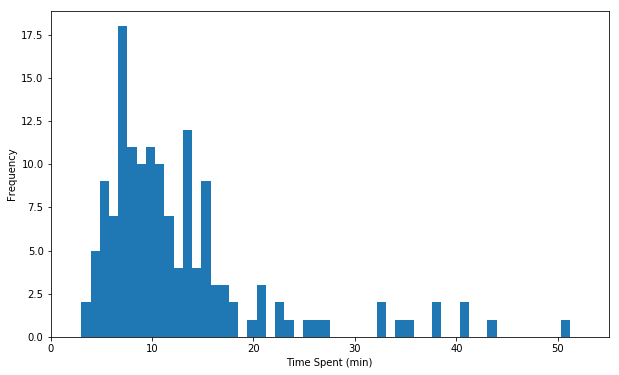

In [34]:
# Check if anyone finished the survey in an unbelievably short amount of time
plt.figure(figsize= (10,6))
plt.hist(df['duration_min'], bins= 2000)
plt.xlabel('Time Spent (min)')
plt.ylabel('Frequency')
plt.xlim(0, 55)
plt.show()

In [26]:
# Summary of the preliminary demographics
print('Total valid participants: %i' % df['reward'].count())
print(df['reward'].value_counts())
demo_tab(df, year= True)

Total valid participants: 153
$10       122
Credit     31
Name: reward, dtype: int64


immersion     CFI DTI IB IRAM SGE SPMI SSO cust/no other  total
program class                                                  
2-year  2020    6  15  5    2   4   10   8       5     1     56
        2021    7   7  4    2   3   27   1      10           61
        2022                                     2            2
AMBA    2020        1       2   1    2          21     2     29
        2021                                     1            1
dual    2021                         1                        1
        2022                                     1            1
other   2020                                     1            1
        2022                                     1            1
total          13  23  9    6   8   40   9      42     3    153

In [35]:
# Demographics with international students
print(df['gender'].value_counts())
demo_tab(df, year= True, intl= True)

Male      76
Female    73
n/d        4
Name: gender, dtype: int64


immersion                   CFI DTI IB IRAM SGE SPMI SSO cust/no other  total
program class intl                                                           
2-year  2020  domestic        4  10  4    2   2   10   6       3           41
              dual                                             1            1
              international   2   5  1        2        2       1     1     14
        2021  domestic        4   4  4    1       18   1       8           40
              dual            1                    1                        2
              international   2   3       1   3    8           2           19
        2022  dual                                             2            2
AMBA    2020  domestic                        1                6     1      8
              international       1       2        2          15     1     21
        2021  domestic                                         1            1
dual    2021  domestic                             1                        1
        2022  international                                    1            1
other   2020  international                                    1            1
        2022  domestic                                         1            1
total                        13  23  9    6   8   40   9      42     3    153

In [36]:
career_tab(df)

post-MBA,Consulting,Creative,Finance,GM,HR,IB,Legal,Marketing,Operations,PE/VC,PM,other,tbd,total
pre-MBA,,,,,,,,,,,,,,
Consulting,13,,2,,,,,2,,1,7,,,25
Creative,1,3,,,,,,,,,,,,4
Education,1,,,,1,,,1,,,,,,3
Engineering,5,,,1,,,,1,,,7,,,14
Entrepreneurship,1,,1,,,,,,,,,,,2
Finance,5,,9,1,,3,,2,,1,2,,1,24
GM,2,,1,4,,,,2,1,,1,,,11
HR,,,,,1,1,,,,,,,1,3
IB,1,,,,,1,,,,,,,,2


In [37]:
# Descriptive analysis
pd.set_option('display.max_columns', None)
#pd.reset_option('display.max_columns')

df.describe().round(2)

,Q6_1,Q6_2,Q6_3,Q6_4,Q6_5,Q6_6,Q6_7,Q6_8,Q6_9,Q6_10,Q7,Q8_1,Q8_2,Q8_3,Q8_4,Q8_5,Q8_6,Q8_7,Q8_8,Q8_9,Q8_10,Q8_11,Q9_1,Q9_2,Q9_3,Q9_4,Q9_5,Q9_6,Q9_7,Q9_8,Q9_9,Q9_10,Q9_11,Q10_1,Q10_2,Q10_3,Q10_4,Q10_5,Q10_6,Q10_7,Q10_8,Q10_9,Q10_10,Q10_11,Q10_12,Q10_13,Q10_14,Q12_1,Q12_2,Q12_3,Q12_4,Q12_5,Q12_6,Q12_7,Q12_8,Q12_9,Q12_10,Q12_11,Q12_12,Q12_13,Q12_14,Q12_15,Q14_1,Q14_2,Q15,Q17,duration_min
count,99.0,25.0,33.0,53.0,61.0,28.0,38.0,82.0,20.0,20.0,153.00,153.00,153.00,153.00,153.00,153.00,153.00,153.00,153.00,153.00,153.00,153.00,153.00,153.00,153.00,153.00,153.00,153.00,153.00,153.00,153.00,153.00,153.00,50.0,36.0,51.0,62.0,53.0,18.0,60.0,88.0,22.0,25.0,45.0,17.0,62.0,23.0,38.0,61.0,59.0,27.0,31.0,27.0,35.0,63.0,73.0,60.0,38.0,62.0,75.0,78.0,38.0,153.00,153.00,153.00,153.00,153.00
mean,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5.45,5.43,5.27,5.58,5.59,5.47,5.58,5.37,5.05,5.45,5.52,4.97,4.81,4.92,5.15,4.66,4.61,4.63,5.09,5.03,5.04,4.30,3.90,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5.66,5.35,5.64,3.48,27.63
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.96,1.32,1.35,1.16,1.13,1.25,1.29,1.20,1.43,1.22,1.24,1.42,1.53,1.50,1.51,1.51,1.50,1.75,1.57,1.50,1.56,1.74,1.69,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.08,1.10,1.42,2.02,147.28
min,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.00,1.00,1.00,1.00,1.00,2.00,1.00,2.00,1.00,2.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.00,2.00,1.00,1.00,3.03
25%,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,4.00,5.00,5.00,4.00,4.00,4.00,4.00,4.00,4.00,4.00,4.00,4.00,4.00,3.00,2.00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5.00,5.00,5.00,2.00,7.45
50%,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5.00,6.00,6.00,6.00,6.00,6.00,6.00,6.00,5.00,6.00,6.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,4.00,4.00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,6.00,5.00,6.00,3.00,10.58
75%,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,6.00,6.00,6.00,6.00,6.00,6.00,6.00,6.00,6.00,6.00,6.00,6.00,6.00,6.00,6.00,6.00,6.00,6.00,6.00,6.00,6.00,6.00,5.00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,6.00,6.00,7.00,5.00,15.28
max,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,7.00,7.00,7.00,7.00,7.00,7.00,7.00,7.00,7.00,7.00,7.00,7.00,7.00,7.00,7.00,7.00,7.00,7.00,7.00,7.00,7.00,7.00,7.00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,7.00,7.00,7.00,7.00,1821.98


# Aggregated Data Analysis

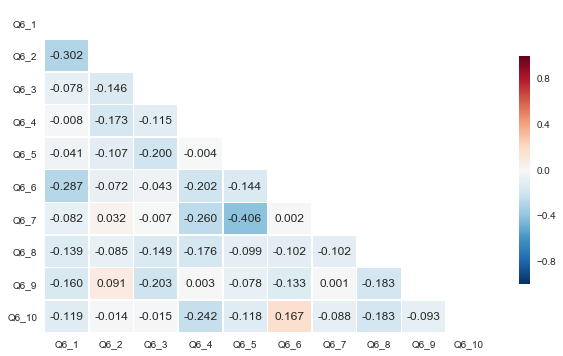

In [38]:
# Correlation of Q6 (MBA goals)
Q6= df.iloc[:, df.columns.get_loc('Q6_1'):df.columns.get_loc('Q6_10')+1].fillna(0)
corr_hmap(Q6, figsize= (10, 6), cbar_shrink= 0.7)

# Low correlation: no need to do a factor analysis

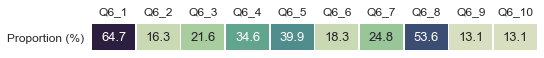

In [39]:
# Q6 (MBA goals) proportion
groupby_pct(Q6, figsize= (8,0.5))

# 64% of the participants selected Q6_1
# 54% of the participants selected Q6_8

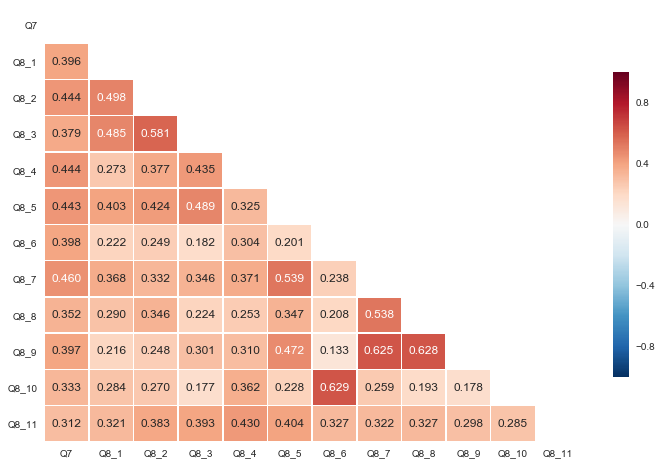

In [40]:
# Correlation of Q7 & Q8 (satisfaction/performance)
Q7Q8= df.iloc[:, df.columns.get_loc('Q7'):df.columns.get_loc('Q8_11')+1]
corr_hmap(Q7Q8, figsize= (12, 8), cbar_shrink= 0.7)

# Fairly correlated, good to go with factor analysis

In [41]:
# Q8 (satisfaction/performance) factor analysis
Q8= df.iloc[:, df.columns.get_loc('Q8_1'):df.columns.get_loc('Q8_11')+1]
factor_variance_Q8, loadings_Q8, transformed_variables_Q8= factor_analysis(Q8, name= 'Q8')
factor_variance_Q8

# 3 factors explaining 64.5% of the variance

(array([2.75575245, 2.45620351, 1.88196027]),
 array([0.25052295, 0.22329123, 0.1710873 ]),
 array([0.25052295, 0.47381418, 0.64490148]))

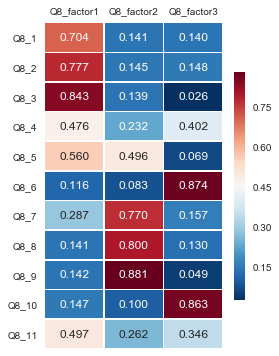

In [42]:
loading_hmap(loadings_Q8, figsize= (4, 6), cbar_shrink= 0.7)

# Factor 1: Q8_1,2,3,5,11 - learning & mental health
# Factor 2: Q8_7,8,9 - recruiting
# Factor 3: Q8_6,10 - social & extracurriculum
# These 3 factors actually form the golden triangle of MBA...lol

In Q7, segments 0 vs. 1: the difference is statistically significant (reject H0)
mean of Q7 when (Q8_segment2 = 0): 4.907, N: 54
mean of Q7 when (Q8_segment2 = 1): 5.747, N: 99
p-value of the difference: 0.000


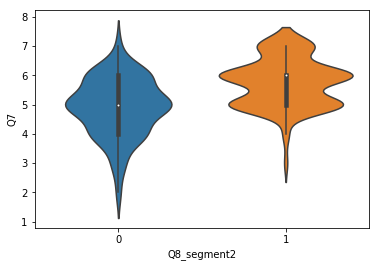

In [43]:
# Q8 (satisfaction/performance) with 2 clusters
Q8_cluster2= KM(transformed_variables_Q8, 2, name= 'Q8')
outcome_variables= 'Q7'
Q8_cluster2[outcome_variables]= df[outcome_variables]
multi_ttest_1d(Q8_cluster2, 'Q8_segment2', outcome_variables, alpha= 0.05, violinplot= True)

# 2 clusters passes the t-test on overall satisfaction 

In Q8_factor1, segments 0 vs. 1: the difference is statistically significant (reject H0)
mean of Q8_factor1 when (Q8_segment2 = 0): -0.514, N: 54
mean of Q8_factor1 when (Q8_segment2 = 1): 0.280, N: 99
p-value of the difference: 0.000


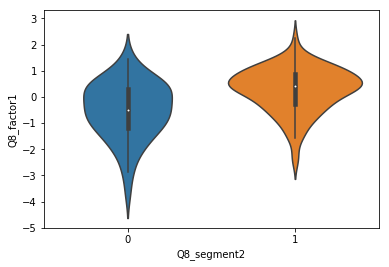

In Q8_factor2, segments 0 vs. 1: the difference is statistically significant (reject H0)
mean of Q8_factor2 when (Q8_segment2 = 0): -0.989, N: 54
mean of Q8_factor2 when (Q8_segment2 = 1): 0.539, N: 99
p-value of the difference: 0.000


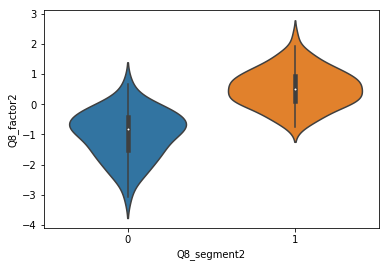

In Q8_factor3, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q8_factor3 when (Q8_segment2 = 0): -0.096, N: 54
mean of Q8_factor3 when (Q8_segment2 = 1): 0.052, N: 99
p-value of the difference: 0.386


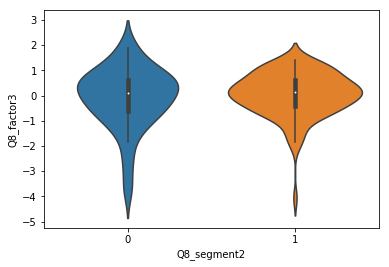

In [44]:
multi_ttest_2d(Q8_cluster2, 'Q8_segment2', ['Q8_factor1', 'Q8_factor2', 'Q8_factor3'], alpha= 0.05, violinplot= True)

In Q7, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q7 when (Q8_segment3 = 0): 5.200, N: 40
mean of Q7 when (Q8_segment3 = 1): 4.950, N: 40
p-value of the difference: 0.262


In Q7, segments 0 vs. 2: the difference is statistically significant (reject H0)
mean of Q7 when (Q8_segment3 = 0): 5.200, N: 40
mean of Q7 when (Q8_segment3 = 2): 5.863, N: 73
p-value of the difference: 0.000


In Q7, segments 1 vs. 2: the difference is statistically significant (reject H0)
mean of Q7 when (Q8_segment3 = 1): 4.950, N: 40
mean of Q7 when (Q8_segment3 = 2): 5.863, N: 73
p-value of the difference: 0.000


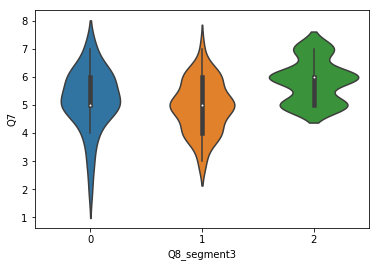

In [45]:
# Q8 (satisfaction/performance) with 3 clusters
Q8_cluster3= KM(transformed_variables_Q8, 3, name= 'Q8')
Q8_cluster3[outcome_variables]= df[outcome_variables]
multi_ttest_1d(Q8_cluster3, 'Q8_segment3', outcome_variables, alpha= 0.05, violinplot= True)

# 3 clusters do not pass the t-test on overall satisfaction

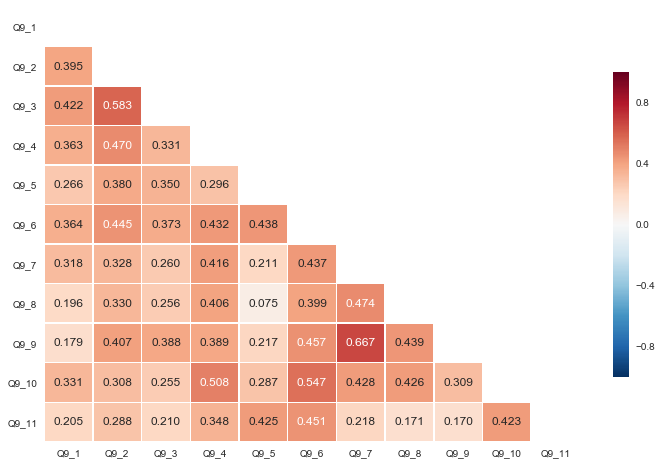

In [46]:
# Correlation of Q9 (help needed/importance)
Q9= df.iloc[:, df.columns.get_loc('Q9_1'):df.columns.get_loc('Q9_11')+1]
corr_hmap(Q9, figsize= (12, 8), cbar_shrink= 0.7)

# Fairly correlated: good to go with factor analysis

In [47]:
# Q9 (help needed/importance) factor analysis
factor_variance_Q9, loadings_Q9, transformed_variables_Q9= factor_analysis(Q9, name= 'Q9')
factor_variance_Q9

# 3 factors explaining 65.8% of the variance

(array([2.6188569 , 2.20186079, 2.137705  ]),
 array([0.2380779 , 0.20016916, 0.19433682]),
 array([0.2380779 , 0.43824706, 0.63258388]))

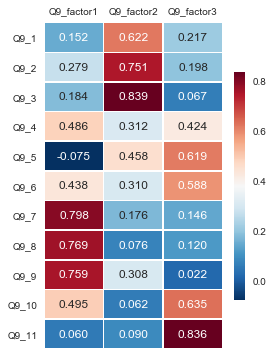

In [48]:
loading_hmap(loadings_Q9, figsize= (4, 6), cbar_shrink= 0.7)

# The loading matrix is a bit rough here, as there is no strong distinction
# There are several correlation coefficients at around 0.4~0.5 across more than 1 factors

In [49]:
# Q9 Q9 (help needed/importance) with 2 clusters
Q9_cluster2= KM(transformed_variables_Q9, 2, name= 'Q9')
Q9_cluster2[outcome_variables]= df[outcome_variables]
multi_ttest_1d(Q9_cluster2, 'Q9_segment2', outcome_variables, alpha= 0.05, violinplot= None)

# 2 clusters fail to pass the t-test on overall satisfaction

In Q7, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q7 when (Q9_segment2 = 0): 5.436, N: 39
mean of Q7 when (Q9_segment2 = 1): 5.456, N: 114
p-value of the difference: 0.910


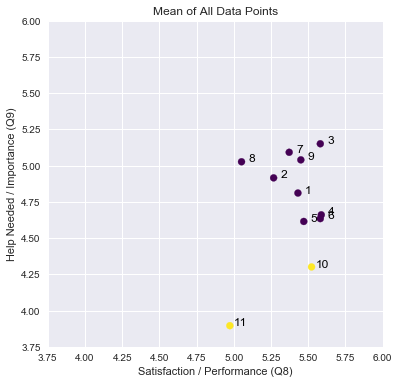

In [50]:
# Plot performance (Q8) vs. importance (Q9) for 11 items
cross_analysis(Q8, Q9, n_cluster= 2, classification= 'KMeans', lim= (3.75, 6))

# The number of clusters is just a judgement call
# Mental health has low importance
# It seems that item 8 have relatively low satisfaction but high importance

In [51]:
# Pair t-tests for satisfaction (Q8) and importance (Q9)
pairs_all= pd.DataFrame({
    'before': Q8.columns.values,
    'after': Q9.columns.values
})

pairs= pd.DataFrame({
    'before': ['Q8_2', 'Q8_8', 'Q8_1', 'Q8_4', 'Q8_5', 'Q8_10'],
    'after': ['Q9_2', 'Q9_8', 'Q9_1', 'Q9_4', 'Q9_5', 'Q9_10']
})

paired_ttest_1d(df, pairs_all, alpha= 0.05, violinplot= None)

# However, item 2 & 8 do not pass the paired t-test
# i.e., the difference between the mean of Q8_8 and Q9_8 are NOT statistically significant, and same for item 2

Q8_1 vs. Q9_1 (N = 153): the difference is statistically significant (reject H0)
mean of Q8_1: 5.431
mean of Q9_1: 4.810
p-value of the difference: 0.000


Q8_2 vs. Q9_2 (N = 153): the difference is statistically significant (reject H0)
mean of Q8_2: 5.268
mean of Q9_2: 4.915
p-value of the difference: 0.039


Q8_3 vs. Q9_3 (N = 153): the difference is statistically significant (reject H0)
mean of Q8_3: 5.582
mean of Q9_3: 5.150
p-value of the difference: 0.008


Q8_4 vs. Q9_4 (N = 153): the difference is statistically significant (reject H0)
mean of Q8_4: 5.588
mean of Q9_4: 4.660
p-value of the difference: 0.000


Q8_5 vs. Q9_5 (N = 153): the difference is statistically significant (reject H0)
mean of Q8_5: 5.471
mean of Q9_5: 4.614
p-value of the difference: 0.000


Q8_6 vs. Q9_6 (N = 153): the difference is statistically significant (reject H0)
mean of Q8_6: 5.582
mean of Q9_6: 4.634
p-value of the difference: 0.000


Q8_7 vs. Q9_7 (N = 153): no difference (fail to reject H0)
mean 

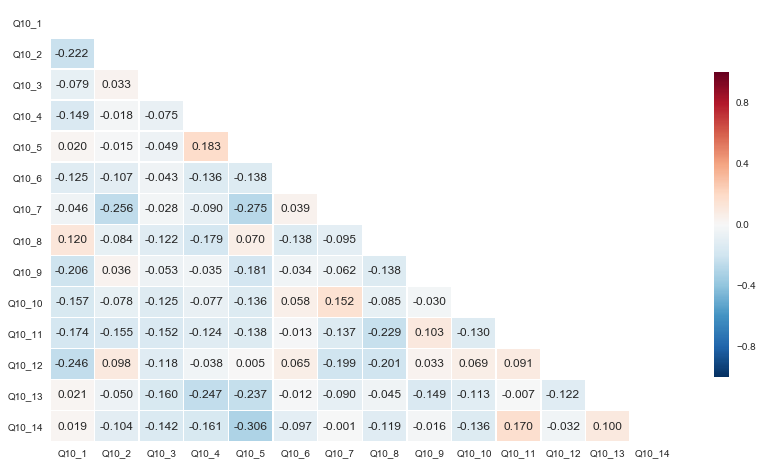

In [52]:
# Correlation of Q10 (solutions)
Q10= df.iloc[:, df.columns.get_loc('Q10_1'):df.columns.get_loc('Q10_14')+1].fillna(0)
corr_hmap(Q10, figsize= (14, 8), cbar_shrink= 0.7)

# Low correlation: no need for factor analysis

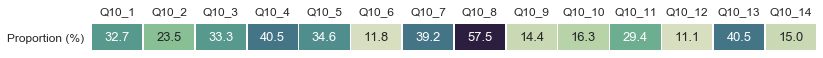

In [53]:
# Q10 (solutions) proportion
groupby_pct(Q10, figsize= (13,0.5))

# 60% of the participants selected Q10_8

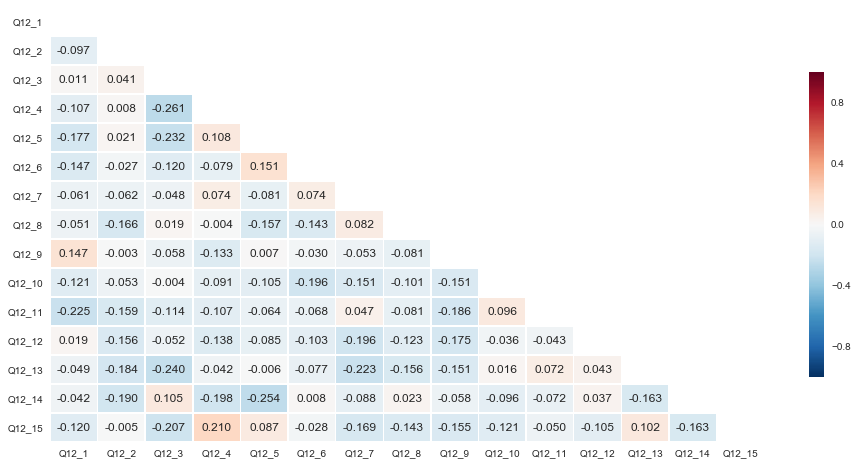

In [54]:
# Correlation of Q12 (product specific)
Q12= df.iloc[:, df.columns.get_loc('Q12_1'):df.columns.get_loc('Q12_15')+1].fillna(0)
corr_hmap(Q12, figsize= (16, 8), cbar_shrink= 0.7)

# Low correlation: no need for factor analysis

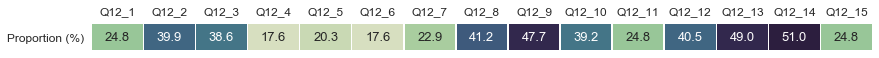

In [55]:
# Q12 (product specific) proportion
groupby_pct(Q12, figsize= (14,0.5))

# Top 3: Q12_14,13,9

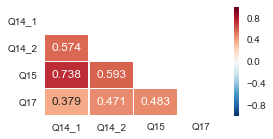

In [56]:
# Correlation of Q14-17 (product specific)
Q1417= df.iloc[:, df.columns.get_loc('Q14_1'):df.columns.get_loc('Q17')+1].fillna(0)
corr_hmap(Q1417, figsize= (4, 2), cbar_shrink= 1)

# Relevance is correlated with usage likelihood, but not so much with likelihood to pay

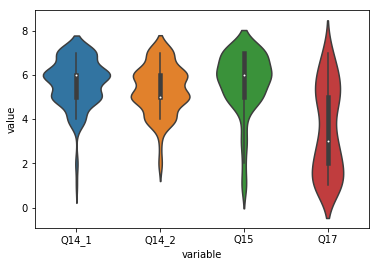

In [57]:
# Q14-17 (product specific) overview
sns.violinplot(x= 'variable', y= 'value', data= pd.melt(Q1417))
plt.show()

# Profiling Analysis (Q8_segment2)

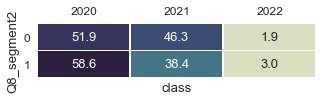

In [58]:
# Demographics of Q8_segment2
df['Q8_segment2']= Q8_cluster2['Q8_segment2']

demographic= 'class'
groupby_pct(df[demographic], segment= Q8_cluster2['Q8_segment2'], single_choice= True, figsize= (5,1))

# Class 2020 more satisfied?

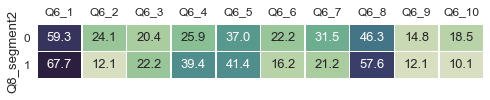

In [59]:
# Q6 (MBA goals) proportion by segments
groupby_pct(Q6, segment= Q8_cluster2['Q8_segment2'], figsize= (8,1))

In [60]:
# Segment analysis by demo
demo_tab(df, year= True, segment= Q8_cluster2['Q8_segment2'], normalize= False)

# SPMI is the only immersion that the classes show the opposite trend

immersion     CFI     DTI     IB    IRAM    SGE    SPMI     SSO    cust/no  \
Q8_segment2     0   1   0   1  0  1    0  1   0  1    0   1   0  1       0   
program class                                                                
2-year  2020    1   5   5  10     5    1  1   2  2    2   8   2  6       3   
        2021    1   6   3   4  2  2       2   2  1   11  16      1       5   
        2022                                                                 
AMBA    2020                1          2      1       1   1              6   
        2021                                                             1   
dual    2021                                              1                  
        2022                                                                 
other   2020                                                             1   
        2022                                                             1   
total           2  11   8  15  2  7    3  3   5  3   14  26   2  7      17   

immersion         other    total  
Q8_segment2     1     0  1        
program class                     
2-year  2020    2     1       56  
        2021    5             61  
        2022    2              2  
AMBA    2020   15        2    29  
        2021                   1  
dual    2021                   1  
        2022    1              1  
other   2020                   1  
        2022                   1  
total          25     1  2   153

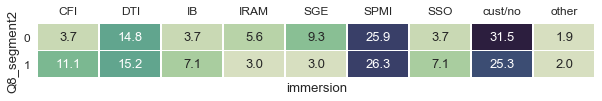

In [61]:
groupby_pct(df['immersion'], segment= Q8_cluster2['Q8_segment2'], single_choice= True, figsize= (10,1))

In [62]:
# Segment analysis by career
career_tab(df, segment= Q8_cluster2['Q8_segment2'])

# top dissatisfied groups: PM, Finance, Marketing, and GM

post-MBA         Consulting     Creative    Finance     GM     HR    IB     \
Q8_segment2               0   1        0  1       0   1  0   1  0  1  0  1   
pre-MBA                                                                      
Consulting                5   8                       2                      
Creative                      1        1  2                                  
Education                     1                                    1         
Engineering               1   4                              1               
Entrepreneurship              1                       1                      
Finance                   1   4                   2   7      1        1  2   
GM                            2                       1      4               
HR                                                                 1     1   
IB                        1                                           1      
Legal                                                 1                      
Marketing                     3                          2                   
Operations                                               2   2               
PM                                                1          1               
Sales                     3   1                       1  1      1            
other                     2   2                   2      2   3           2   
total                    13  27        1  2       5  13  7  12  1  2  2  5   

post-MBA         Legal Marketing     Operations PE/VC  PM     other    tbd     \
Q8_segment2          0         0   1          1     0   0   1     0  1   0  1   
pre-MBA                                                                         
Consulting                     1   1                1   2   5                   
Creative                                                                        
Education                          1                                            
Engineering                    1                        4   3                   
Entrepreneurship                                                                
Finance                            2                1   1   1            1      
GM                                 2          1         1                       
HR                                                                       1      
IB                                                                              
Legal                1                                      1                   
Marketing                      1   3                    1   1        1   1      
Operations                                                  1     1             
PM                             1                        2   5                   
Sales                          1   2                    2   2                   
other                              4                                 1      1   
total                1         5  15          1     2  13  19     1  2   3  1   

post-MBA         total  
Q8_segment2             
pre-MBA                 
Consulting          25  
Creative             4  
Education            3  
Engineering         14  
Entrepreneurship     2  
Finance             24  
GM                  11  
HR                   3  
IB                   2  
Legal                3  
Marketing           13  
Operations           6  
PM                  10  
Sales               14  
other               19  
total              153

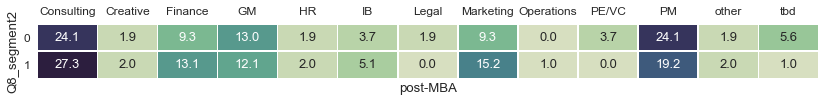

In [63]:
groupby_pct(df['post-MBA'], segment= Q8_cluster2['Q8_segment2'], single_choice= True, figsize= (14,1))

In [64]:
# Q8 factors by segment 0 & 1
Q8_cluster2[['Q8_factor1', 'Q8_factor2', 'Q8_factor3']].groupby(
    Q8_cluster2['Q8_segment2']).agg(['mean', 'std', 'count']).round(3)

# Factor 1: Q8_1,2,3,5,11 - learning & mental health
# Factor 2: Q8_7,8,9 - recruiting
# Factor 3: Q8_6,10 - social

Q8_factor1              Q8_factor2              Q8_factor3         \
                  mean    std count       mean    std count       mean    std   
Q8_segment2                                                                     
0               -0.514  1.075    54     -0.989  0.789    54     -0.096  1.211   
1                0.280  0.844    99      0.539  0.626    99      0.052  0.872   

                   
            count  
Q8_segment2        
0              54  
1              99

In [65]:
# Q9 by segment 0 & 1
Q9.groupby(Q8_cluster2['Q8_segment2']).agg(['mean', 'std']).round(2)

Q9_1        Q9_2        Q9_3        Q9_4        Q9_5        Q9_6  \
             mean   std  mean   std  mean   std  mean   std  mean   std  mean   
Q8_segment2                                                                     
0            4.83  1.40  4.87  1.40  5.02  1.45  4.80  1.17  4.57  1.31  4.91   
1            4.80  1.61  4.94  1.56  5.22  1.54  4.59  1.67  4.64  1.59  4.48   

                   Q9_7        Q9_8        Q9_9       Q9_10       Q9_11        
              std  mean   std  mean   std  mean   std  mean   std  mean   std  
Q8_segment2                                                                    
0            1.25  5.24  1.27  5.09  1.35  5.28  1.19  4.63  1.25  4.22  1.42  
1            1.96  5.01  1.72  4.99  1.59  4.91  1.73  4.12  1.94  3.72  1.81

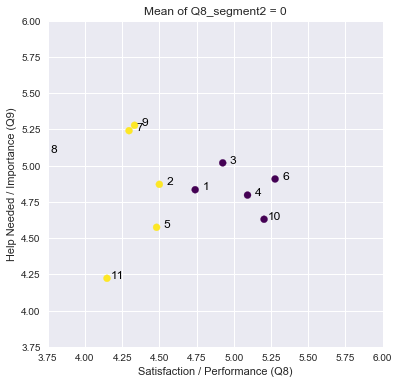

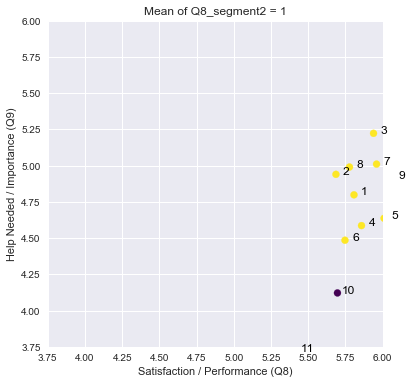

In [66]:
# Plot performance (Q8) vs. importance (Q9) for 11 items by Q8_segment2
cross_analysis_1d(Q8, Q9, segment= Q8_cluster2['Q8_segment2'], n_cluster= 2, lim= (3.75, 6))

# Dissatisfied segment have a prioritized importance (key finding)

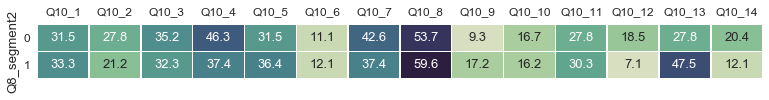

In [67]:
# Q10 proportion by segments
groupby_pct(Q10, segment= Q8_cluster2['Q8_segment2'], figsize= (13,1))

# 59% of segment 0 selected Q10_8
# 53% of segment 0 selected Q10_4

# 60% of segment 1 selected Q10_8
# 53% of segment 1 selected Q10_13

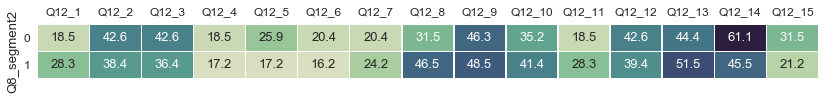

In [68]:
# Q12 proportion by segments
groupby_pct(Q12, segment= Q8_cluster2['Q8_segment2'], figsize= (14,1))

# 65% of segment 0 selected Q12_14
# 54% of segment 1 selected Q12_13

# Analysis by Graduation Year

In [69]:
# Create a dummy variable for class of 2020 (graduating class)
df['class_2020']= (df['class'] == '2020').astype(int)

In [70]:
# Fisher's exact test with Q8_segment2
# Use Fisher's test here because the sample size is small
table, results= rp.crosstab(df['Q8_segment2'], df['class_2020'], test= 'fisher')
results
# They have a relationship! (Key finding)

,Fisher's exact test,results
0,Odds ratio =,1.3136
1,2 sided p-value =,0.4959
2,Left tail p-value =,0.8347
3,Right tail p-value =,0.2634
4,Cramer's phi =,0.0649


In [71]:
# Class of 2020 by career
class_2020= df.loc[df['class_2020'] == 1]
career_tab(class_2020, segment= class_2020['Q8_segment2'])

post-MBA    Consulting     Finance    GM    HR IB Marketing    Operations  \
Q8_segment2          0   1       0  1  0  1  1  1         0  1          1   
pre-MBA                                                                     
Consulting           4   6          1                                       
Education                1                   1               1              
Engineering              2                1               1                 
Finance              1   3       2  6           2            1              
GM                       2          1     2                  1          1   
HR                                              1                           
Marketing                2             2                     2              
Operations                                1                                 
PM                                        1               1                 
Sales                1   1          1  1                     1              
other                2   1       2     1  2                  1              
total                8  18       4  9  4  7  1  3         2  7          1   

post-MBA    PE/VC PM    other    tbd    total  
Q8_segment2     0  0  1     0  1   0  1        
pre-MBA                                        
Consulting      1     2                    14  
Education                                   3  
Engineering        2  1                     7  
Finance         1     1            1       18  
GM                 1                        8  
HR                                 1        2  
Marketing             1        1            8  
Operations            1     1               3  
PM                 1  2                     5  
Sales              1  1                     7  
other                          1      1    11  
total           2  5  9     1  2   2  1    86

In [72]:
# Not class of 2020 by career
class_not2020= df.loc[df['class_2020'] == 0]
career_tab(class_not2020, segment= class_not2020['Q8_segment2'])

post-MBA         Consulting    Creative    Finance    GM    HR    IB    Legal  \
Q8_segment2               0  1        0  1       0  1  0  1  0  1  0  1     0   
pre-MBA                                                                         
Consulting                1  2                      1                           
Creative                     1        1  2                                      
Engineering               1  2                                                  
Entrepreneurship             1                      1                           
Finance                      1                      1     1        1            
GM                                                        2                     
HR                                                              1               
IB                        1                                        1            
Legal                                               1                       1   
Marketing                    1                                                  
Operations                                             2  1                     
PM                                               1                              
Sales                     2                                  1                  
other                        1                         1  1           2         
total                     5  9        1  2       1  4  3  5  1  1  2  2     1   

post-MBA         Marketing    PM     tbd total  
Q8_segment2              0  1  0   1   0        
pre-MBA                                         
Consulting               1  1  2   3        11  
Creative                                     4  
Engineering                    2   2         7  
Entrepreneurship                             2  
Finance                     1  1             6  
GM                          1                3  
HR                                           1  
IB                                           2  
Legal                              1         3  
Marketing                1  1  1       1     5  
Operations                                   3  
PM                             1   3         5  
Sales                    1  1  1   1         7  
other                       3                8  
total                    3  8  8  10   1    67

In [73]:
# T-test for 2020 vs. non-2020 on overall satisfaction
multi_ttest_1d(df, 'class_2020', 'Q7', alpha= 0.05, violinplot= None)

In Q7, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q7 when (class_2020 = 0): 5.463, N: 67
mean of Q7 when (class_2020 = 1): 5.442, N: 86
p-value of the difference: 0.895


In [74]:
# T-test for 2020 vs. non-2020 on satisfaction (Q8)
Q8_clusters= transformed_variables_Q8.columns.values
df[Q8_clusters]= Q8_cluster2[Q8_clusters]
multi_ttest_2d(df, 'class_2020', Q8_clusters, alpha= 0.05, violinplot= None)

# No difference

In Q8_factor1, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q8_factor1 when (class_2020 = 0): 0.120, N: 67
mean of Q8_factor1 when (class_2020 = 1): -0.094, N: 86
p-value of the difference: 0.191
In Q8_factor2, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q8_factor2 when (class_2020 = 0): -0.138, N: 67
mean of Q8_factor2 when (class_2020 = 1): 0.107, N: 86
p-value of the difference: 0.134
In Q8_factor3, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q8_factor3 when (class_2020 = 0): 0.115, N: 67
mean of Q8_factor3 when (class_2020 = 1): -0.090, N: 86
p-value of the difference: 0.211


In [75]:
# T-test for 2020 vs. non-2020 on importance (Q9)
multi_ttest_2d(df, 'class_2020', Q9.columns.values, alpha= 0.05, violinplot= None)

# No difference

In Q9_1, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q9_1 when (class_2020 = 0): 4.896, N: 67
mean of Q9_1 when (class_2020 = 1): 4.744, N: 86
p-value of the difference: 0.547
In Q9_2, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q9_2 when (class_2020 = 0): 4.866, N: 67
mean of Q9_2 when (class_2020 = 1): 4.953, N: 86
p-value of the difference: 0.721
In Q9_3, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q9_3 when (class_2020 = 0): 5.224, N: 67
mean of Q9_3 when (class_2020 = 1): 5.093, N: 86
p-value of the difference: 0.596
In Q9_4, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q9_4 when (class_2020 = 0): 4.567, N: 67
mean of Q9_4 when (class_2020 = 1): 4.733, N: 86
p-value of the difference: 0.504
In Q9_5, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q9_5 when (class_2020 = 0): 4.627, N: 67
mean of Q9_5 when (class_2020 = 1): 4.605, N: 86
p-value of the difference: 0.928
In Q9_6, segments 0 vs. 1: no difference

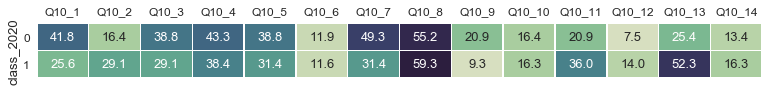

In [76]:
# Q10 proportion by class_2020
groupby_pct(Q10, segment= df['class_2020'], figsize= (13,1))

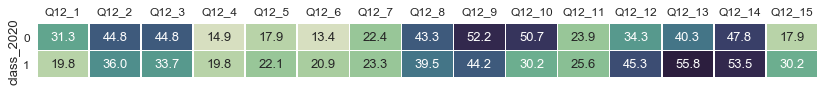

In [77]:
# Q12 proportion by class_2020
groupby_pct(Q12, segment= df['class_2020'], figsize= (14,1))

# Analysis by Graduation Year within 2-year Program

In [78]:
# Create a subset of SPMI data
two_year= df.loc[df['program'] == '2-year'].fillna(0)

In [79]:
# Fisher's exact test with Q8_segment2
# Use Fisher's test here because the sample size is small
table, results= rp.crosstab(two_year['Q8_segment2'], two_year['class_2020'], test= 'fisher')
results
# Significant Relationship between graduation years within 2-year program, but no difference in factors

,Fisher's exact test,results
0,Odds ratio =,1.4118
1,2 sided p-value =,0.4413
2,Left tail p-value =,0.8600
3,Right tail p-value =,0.2444
4,Cramer's phi =,0.0813


In [80]:
# T-test for 2020 vs. non-2020 on overall satisfaction
multi_ttest_1d(two_year, 'class_2020', 'Q7', alpha= 0.05, violinplot= None)

In Q7, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q7 when (class_2020 = 0): 5.429, N: 63
mean of Q7 when (class_2020 = 1): 5.518, N: 56
p-value of the difference: 0.619


In [81]:
# T-test for SPMI vs. non-SPMI on satisfaction (Q8)
multi_ttest_2d(two_year, 'class_2020', Q8_clusters, alpha= 0.05, violinplot= None)

In Q8_factor1, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q8_factor1 when (class_2020 = 0): 0.103, N: 63
mean of Q8_factor1 when (class_2020 = 1): -0.213, N: 56
p-value of the difference: 0.103
In Q8_factor2, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q8_factor2 when (class_2020 = 0): -0.136, N: 63
mean of Q8_factor2 when (class_2020 = 1): 0.206, N: 56
p-value of the difference: 0.071
In Q8_factor3, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q8_factor3 when (class_2020 = 0): 0.149, N: 63
mean of Q8_factor3 when (class_2020 = 1): -0.103, N: 56
p-value of the difference: 0.177


# PM Analysis

In [82]:
# Create a dummy variable to separate SPMI cohort
df['is_PM']= (df['post-MBA'] == 'PM').astype(int)

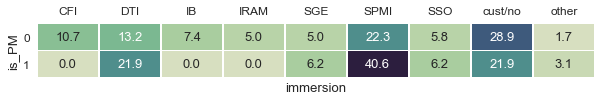

In [83]:
groupby_pct(df['immersion'], segment= df['is_PM'], single_choice= True, figsize= (10,1))

In [84]:
# T-test on overall satisfaction
multi_ttest_1d(df, 'is_PM', 'Q7', alpha= 0.05, violinplot= None)

In Q7, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q7 when (is_PM = 0): 5.413, N: 121
mean of Q7 when (is_PM = 1): 5.594, N: 32
p-value of the difference: 0.345


In [85]:
# T-test on satisfaction (Q8)
multi_ttest_2d(df, 'is_PM', Q8_clusters, alpha= 0.05, violinplot= None)

In Q8_factor1, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q8_factor1 when (is_PM = 0): -0.031, N: 121
mean of Q8_factor1 when (is_PM = 1): 0.118, N: 32
p-value of the difference: 0.455
In Q8_factor2, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q8_factor2 when (is_PM = 0): 0.077, N: 121
mean of Q8_factor2 when (is_PM = 1): -0.292, N: 32
p-value of the difference: 0.064
In Q8_factor3, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q8_factor3 when (is_PM = 0): -0.049, N: 121
mean of Q8_factor3 when (is_PM = 1): 0.186, N: 32
p-value of the difference: 0.240


In [86]:
# T-test on importance (Q9)
multi_ttest_2d(df, 'is_PM', Q9.columns.values, alpha= 0.05, violinplot= None)

In Q9_1, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q9_1 when (is_PM = 0): 4.818, N: 121
mean of Q9_1 when (is_PM = 1): 4.781, N: 32
p-value of the difference: 0.904
In Q9_2, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q9_2 when (is_PM = 0): 4.884, N: 121
mean of Q9_2 when (is_PM = 1): 5.031, N: 32
p-value of the difference: 0.625
In Q9_3, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q9_3 when (is_PM = 0): 5.116, N: 121
mean of Q9_3 when (is_PM = 1): 5.281, N: 32
p-value of the difference: 0.582
In Q9_4, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q9_4 when (is_PM = 0): 4.669, N: 121
mean of Q9_4 when (is_PM = 1): 4.625, N: 32
p-value of the difference: 0.883
In Q9_5, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q9_5 when (is_PM = 0): 4.545, N: 121
mean of Q9_5 when (is_PM = 1): 4.875, N: 32
p-value of the difference: 0.269
In Q9_6, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q9_6 when (is_PM

# SPMI Analysis

In [87]:
# Create a dummy variable to separate SPMI cohort
df['is_SPMI']= (df['immersion'] == 'SPMI').astype(int)

In [88]:
# T-test for SPMI vs. non-SPMI on overall satisfaction
multi_ttest_1d(df, 'is_SPMI', 'Q7', alpha= 0.05, violinplot= None)

In Q7, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q7 when (is_SPMI = 0): 5.372, N: 113
mean of Q7 when (is_SPMI = 1): 5.675, N: 40
p-value of the difference: 0.086


In [89]:
# T-test for SPMI vs. non-SPMI on satisfaction (Q8)
multi_ttest_2d(df, 'is_SPMI', Q8_clusters, alpha= 0.05, violinplot= None)

# Factor 3?

In Q8_factor1, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q8_factor1 when (is_SPMI = 0): -0.011, N: 113
mean of Q8_factor1 when (is_SPMI = 1): 0.032, N: 40
p-value of the difference: 0.815
In Q8_factor2, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q8_factor2 when (is_SPMI = 0): 0.003, N: 113
mean of Q8_factor2 when (is_SPMI = 1): -0.009, N: 40
p-value of the difference: 0.946
In Q8_factor3, segments 0 vs. 1: the difference is statistically significant (reject H0)
mean of Q8_factor3 when (is_SPMI = 0): -0.104, N: 113
mean of Q8_factor3 when (is_SPMI = 1): 0.293, N: 40
p-value of the difference: 0.031


In [90]:
# T-test for SPMI vs. non-SPMI on importance (Q9)
multi_ttest_2d(df, 'is_SPMI', Q9.columns.values, alpha= 0.05, violinplot= None)

# No difference

In Q9_1, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q9_1 when (is_SPMI = 0): 4.832, N: 113
mean of Q9_1 when (is_SPMI = 1): 4.750, N: 40
p-value of the difference: 0.773
In Q9_2, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q9_2 when (is_SPMI = 0): 4.885, N: 113
mean of Q9_2 when (is_SPMI = 1): 5.000, N: 40
p-value of the difference: 0.679
In Q9_3, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q9_3 when (is_SPMI = 0): 5.062, N: 113
mean of Q9_3 when (is_SPMI = 1): 5.400, N: 40
p-value of the difference: 0.224
In Q9_4, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q9_4 when (is_SPMI = 0): 4.664, N: 113
mean of Q9_4 when (is_SPMI = 1): 4.650, N: 40
p-value of the difference: 0.961
In Q9_5, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q9_5 when (is_SPMI = 0): 4.566, N: 113
mean of Q9_5 when (is_SPMI = 1): 4.750, N: 40
p-value of the difference: 0.507
In Q9_6, segments 0 vs. 1: no difference (fail to reject H0)
mean

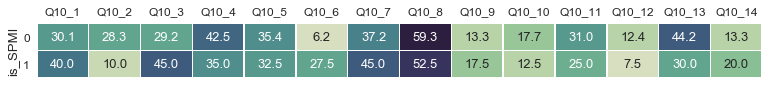

In [91]:
# Q10 proportion by is_SPMI
groupby_pct(Q10, segment= df['is_SPMI'], figsize= (13,1))

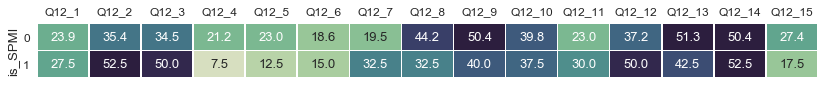

In [92]:
# Q12 proportion by is_SPMI
groupby_pct(Q12, segment= df['is_SPMI'], figsize= (14,1))

# SPMI Analysis by Graduation Year

In [93]:
# Create a subset of SPMI data
SPMI= df.loc[df['immersion'] == 'SPMI'].fillna(0)
#SPMI.reset_index(inplace= True)

In [94]:
# Fisher's exact test with Q8_segment2
# Use Fisher's test here because the sample size is small
table, results= rp.crosstab(SPMI['Q8_segment2'], SPMI['class_2020'], test= 'fisher')
results

,Fisher's exact test,results
0,Odds ratio =,1.9412
1,2 sided p-value =,0.4844
2,Left tail p-value =,0.8924
3,Right tail p-value =,0.3112
4,Cramer's phi =,0.1373


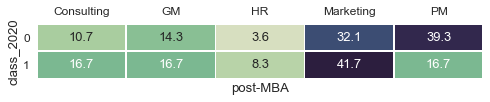

In [95]:
# Career aspiration by class within SPMI
groupby_pct(SPMI['post-MBA'], segment= SPMI['class_2020'], single_choice= True, figsize= (8,1))

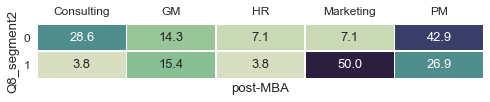

In [96]:
# Career aspiration by Q8_segment2
groupby_pct(SPMI['post-MBA'], segment= SPMI['Q8_segment2'], single_choice= True, figsize= (8,1))

In [97]:
# T-test for SPMI class of 2020 vs. 2021 on overall satisfaction
multi_ttest_1d(SPMI, 'class_2020', 'Q7', alpha= 0.05, violinplot= None)

# Class of 2021 are less satisfied than class of 2020 (key finding)

In Q7, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q7 when (class_2020 = 0): 5.607, N: 28
mean of Q7 when (class_2020 = 1): 5.833, N: 12
p-value of the difference: 0.398


In [98]:
# T-test for SPMI class of 2020 vs. 2021 on satisfaction (Q8)
multi_ttest_2d(SPMI, 'class_2020', Q8_clusters, alpha= 0.05, violinplot= None)

# The differences in factor 2 are significant (Key finding)

In Q8_factor1, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q8_factor1 when (class_2020 = 0): 0.134, N: 28
mean of Q8_factor1 when (class_2020 = 1): -0.206, N: 12
p-value of the difference: 0.387
In Q8_factor2, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q8_factor2 when (class_2020 = 0): -0.232, N: 28
mean of Q8_factor2 when (class_2020 = 1): 0.509, N: 12
p-value of the difference: 0.061
In Q8_factor3, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q8_factor3 when (class_2020 = 0): 0.218, N: 28
mean of Q8_factor3 when (class_2020 = 1): 0.468, N: 12
p-value of the difference: 0.368


In [99]:
# T-test for SPMI vs. non-SPMI on importance (Q9)
multi_ttest_2d(SPMI, 'class_2020', Q9.columns.values, alpha= 0.05, violinplot= None)

# The difference in Q9_7 (career networking) is significant

In Q9_1, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q9_1 when (class_2020 = 0): 4.786, N: 28
mean of Q9_1 when (class_2020 = 1): 4.667, N: 12
p-value of the difference: 0.834
In Q9_2, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q9_2 when (class_2020 = 0): 4.857, N: 28
mean of Q9_2 when (class_2020 = 1): 5.333, N: 12
p-value of the difference: 0.365
In Q9_3, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q9_3 when (class_2020 = 0): 5.179, N: 28
mean of Q9_3 when (class_2020 = 1): 5.917, N: 12
p-value of the difference: 0.161
In Q9_4, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q9_4 when (class_2020 = 0): 4.643, N: 28
mean of Q9_4 when (class_2020 = 1): 4.667, N: 12
p-value of the difference: 0.962
In Q9_5, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q9_5 when (class_2020 = 0): 4.464, N: 28
mean of Q9_5 when (class_2020 = 1): 5.417, N: 12
p-value of the difference: 0.065
In Q9_6, segments 0 vs. 1: no difference

In [100]:
# Case summary for the variables with significant difference
SPMI[['Q7', 'Q8_factor2', 'Q9_7']].groupby(SPMI['class_2020']).agg(['mean', 'std', 'count']).round(3)

Q7              Q8_factor2                Q9_7             
             mean    std count       mean    std count   mean    std count
class_2020                                                                
0           5.607  0.786    28     -0.232  1.273    28  5.393  1.423    28
1           5.833  0.718    12      0.509  0.546    12  4.333  1.826    12

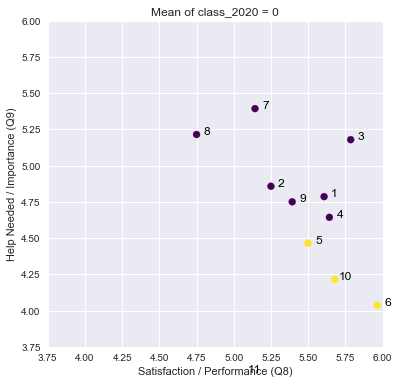

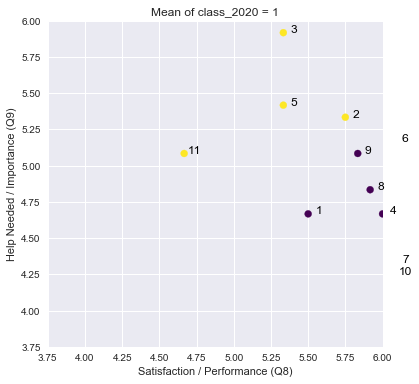

In [101]:
# Plot performance (Q8) vs. importance (Q9) for 11 items 
Q8_SPMI= SPMI[Q8.columns.values]
Q9_SPMI= SPMI[Q9.columns.values]
cross_analysis_1d(Q8_SPMI, Q9_SPMI, segment= SPMI['class_2020'], n_cluster= 2, 
                  classification= 'KMeans', lim= (3.75, 6))

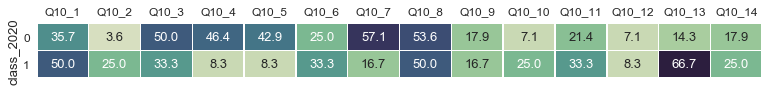

In [102]:
# Q10 proportion by class in SPMI
groupby_pct(SPMI[Q10.columns.values], segment= SPMI['class_2020'], figsize= (13,1))

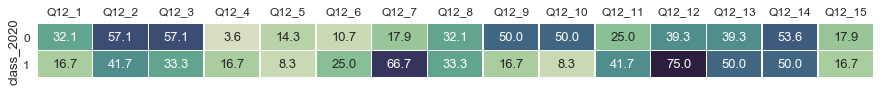

In [103]:
# Q12 proportion by class in SPMI
groupby_pct(SPMI[Q12.columns.values], segment= SPMI['class_2020'], figsize= (15,1))

In [104]:
# Class of 2020 SPMI by career
SPMI_2020= SPMI.loc[SPMI['class_2020'] == 1]
career_tab(SPMI_2020, segment= SPMI_2020['Q8_segment2'], axis= 1)

post-MBA    Consulting GM HR Marketing PM    total
Q8_segment2          0  1  1         1  0  1      
pre-MBA                                           
Education                  1         1           2
Engineering                             1        1
Finance              1               1           2
GM                                   1           1
PM                      1                        1
Sales                                1     1     2
other                1  1            1           3
total                2  2  1         5  1  1    12

In [105]:
# Not class of 2020 SPMI by career
SPMI_not2020= SPMI.loc[SPMI['class_2020'] == 0]
career_tab(SPMI_not2020, segment= SPMI_not2020['Q8_segment2'], axis= 1)

# PMs not in class of 2020 are dissatisfied (key finding)

post-MBA    Consulting    GM    HR Marketing    PM    total
Q8_segment2          0  1  0  1  0         0  1  0  1      
pre-MBA                                                    
Consulting                                    1     2     3
Engineering          1  1                        2        4
Finance                                       1  1        2
GM                            1               1           2
Marketing                                  1  1  1        3
Operations                 1                              1
PM                                               1  3     4
Sales                1           1            1     1     4
other                      1  1               3           5
total                2  1  2  2  1         1  8  5  6    28

# Analysis of SPMI not in class of 2020

In [106]:
# Create a dummy variable
df['SPMI_not2020']= ((df['immersion'] == 'SPMI') & (df['class'] != '2020')).astype(int)

In [107]:
# Fisher's exact test with Q8_segment2
# Use Fisher's test here because the sample size is small
table, results= rp.crosstab(df['Q8_segment2'], df['SPMI_not2020'], test= 'fisher')
results

# They have a relationship! (Key finding)

,Fisher's exact test,results
0,Odds ratio =,0.8104
1,2 sided p-value =,0.6648
2,Left tail p-value =,0.3888
3,Right tail p-value =,0.7624
4,Cramer's phi =,0.0395


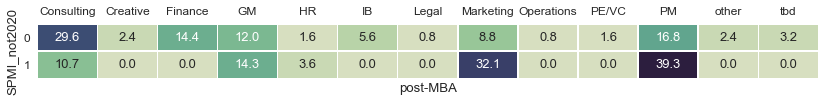

In [108]:
# By career aspiration
groupby_pct(df['post-MBA'], segment= df['SPMI_not2020'], single_choice= True, figsize= (14,1))

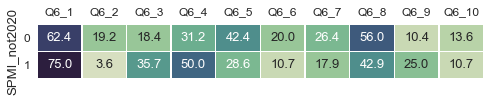

In [109]:
# Q6 (MBA goals) proportion 
groupby_pct(Q6, segment= df['SPMI_not2020'], figsize= (8,1))

In [110]:
# T-test on Q7 (overall satisfaction) 
multi_ttest_1d(df, 'SPMI_not2020', 'Q7', alpha= 0.05, violinplot= None)

In Q7, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q7 when (SPMI_not2020 = 0): 5.416, N: 125
mean of Q7 when (SPMI_not2020 = 1): 5.607, N: 28
p-value of the difference: 0.342


In [111]:
# T-test on Q8 (satisfaction)
multi_ttest_2d(df, 'SPMI_not2020', Q8_clusters, alpha= 0.05, violinplot= None)

# SPMI_not2020 are not satisfied with recruiting (key finding)

In Q8_factor1, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q8_factor1 when (SPMI_not2020 = 0): -0.030, N: 125
mean of Q8_factor1 when (SPMI_not2020 = 1): 0.134, N: 28
p-value of the difference: 0.437
In Q8_factor2, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q8_factor2 when (SPMI_not2020 = 0): 0.052, N: 125
mean of Q8_factor2 when (SPMI_not2020 = 1): -0.232, N: 28
p-value of the difference: 0.178
In Q8_factor3, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q8_factor3 when (SPMI_not2020 = 0): -0.049, N: 125
mean of Q8_factor3 when (SPMI_not2020 = 1): 0.218, N: 28
p-value of the difference: 0.205


In [112]:
# T-test on importance (Q9)
multi_ttest_2d(df, 'SPMI_not2020', Q9.columns.values, alpha= 0.05, violinplot= None)

# Significant differece in Q9_7 (career networking)

In Q9_1, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q9_1 when (SPMI_not2020 = 0): 4.816, N: 125
mean of Q9_1 when (SPMI_not2020 = 1): 4.786, N: 28
p-value of the difference: 0.925
In Q9_2, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q9_2 when (SPMI_not2020 = 0): 4.928, N: 125
mean of Q9_2 when (SPMI_not2020 = 1): 4.857, N: 28
p-value of the difference: 0.823
In Q9_3, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q9_3 when (SPMI_not2020 = 0): 5.144, N: 125
mean of Q9_3 when (SPMI_not2020 = 1): 5.179, N: 28
p-value of the difference: 0.913
In Q9_4, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q9_4 when (SPMI_not2020 = 0): 4.664, N: 125
mean of Q9_4 when (SPMI_not2020 = 1): 4.643, N: 28
p-value of the difference: 0.947
In Q9_5, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q9_5 when (SPMI_not2020 = 0): 4.648, N: 125
mean of Q9_5 when (SPMI_not2020 = 1): 4.464, N: 28
p-value of the difference: 0.559
In Q9_6, segmen

In [113]:
# Case summary for the variables with significant difference
df[['Q8_factor2', 'Q9_7']].groupby(df['SPMI_not2020']).agg(['mean', 'std', 'count']).round(3)

Q8_factor2                Q9_7             
                   mean    std count   mean    std count
SPMI_not2020                                            
0                 0.052  0.931   125  5.024  1.604   125
1                -0.232  1.273    28  5.393  1.423    28

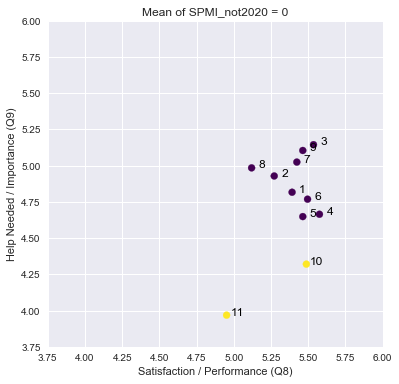

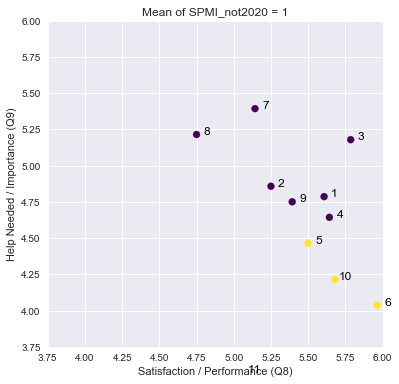

In [114]:
# Plot performance (Q8) vs. importance (Q9) for 11 items by SPMI_non2020
cross_analysis_1d(Q8, Q9, segment= df['SPMI_not2020'], n_cluster= 2, classification= 'KMeans', lim= (3.75, 6))

# SPMI_non2020 have a prioritized importance, but not as clearly defined as PM_not2020

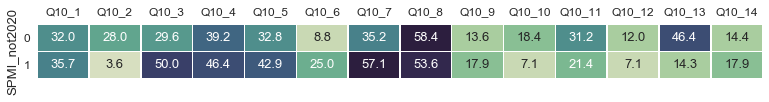

In [115]:
# Q10 proportion by SPMI_not2020
groupby_pct(Q10, segment= df['SPMI_not2020'], figsize= (13,1))

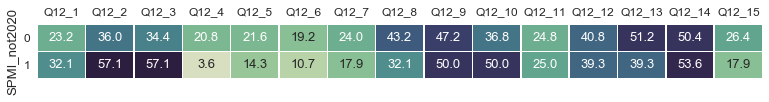

In [116]:
# Q12 proportion by SPMI_not2020
groupby_pct(Q12, segment= df['SPMI_not2020'], figsize= (13,1))

In [117]:
# Q1417 by SPMI_not2020
Q1417.groupby(df['SPMI_not2020']).agg(['mean', 'std', 'count']).round(3)

Q14_1               Q14_2                 Q15               \
               mean    std count   mean    std count   mean    std count   
SPMI_not2020                                                               
0             5.552  1.088   125  5.240  1.095   125  5.536  1.468   125   
1             6.143  0.891    28  5.821  0.983    28  6.107  1.066    28   

                Q17               
               mean    std count  
SPMI_not2020                      
0             3.472  2.026   125  
1             3.536  2.009    28

# Analysis of Aspiring PMs not in class of 2020

In [118]:
# Create a dummy variable
df['PM_not2020']= ((df['post-MBA'] == 'PM') & (df['class'] != '2020')).astype(int)

In [119]:
# Fisher's exact test with Q8_segment2
# Use Fisher's test here because the sample size is small
table, results= rp.crosstab(df['Q8_segment2'], df['PM_not2020'], test= 'fisher')
results

,Fisher's exact test,results
0,Odds ratio =,0.6461
1,2 sided p-value =,0.4354
2,Left tail p-value =,0.2697
3,Right tail p-value =,0.8695
4,Cramer's phi =,0.0699


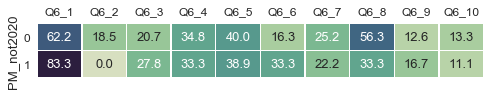

In [120]:
# Q6 (MBA goals) proportion by segments
groupby_pct(Q6, segment= df['PM_not2020'], figsize= (8,1))

In [121]:
# T-test on Q7 (overall satisfaction) 
multi_ttest_1d(df, 'PM_not2020', 'Q7', alpha= 0.05, violinplot= None)

In Q7, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q7 when (PM_not2020 = 0): 5.437, N: 135
mean of Q7 when (PM_not2020 = 1): 5.556, N: 18
p-value of the difference: 0.624


In [122]:
# T-test on Q8 (satisfaction)
multi_ttest_2d(df, 'PM_not2020', Q8_clusters, alpha= 0.05, violinplot= None)

# PM_not2020 are not satisfied with recruiting (key finding)

In Q8_factor1, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q8_factor1 when (PM_not2020 = 0): -0.057, N: 135
mean of Q8_factor1 when (PM_not2020 = 1): 0.430, N: 18
p-value of the difference: 0.053
In Q8_factor2, segments 0 vs. 1: the difference is statistically significant (reject H0)
mean of Q8_factor2 when (PM_not2020 = 0): 0.075, N: 135
mean of Q8_factor2 when (PM_not2020 = 1): -0.561, N: 18
p-value of the difference: 0.011
In Q8_factor3, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q8_factor3 when (PM_not2020 = 0): -0.042, N: 135
mean of Q8_factor3 when (PM_not2020 = 1): 0.312, N: 18
p-value of the difference: 0.161


In [123]:
# Q8 factors by PM_not2020
Q8_cluster2[['Q8_factor1', 'Q8_factor2', 'Q8_factor3']].groupby(
    df['PM_not2020']).agg(['mean', 'std', 'count']).round(3)

Q8_factor1              Q8_factor2              Q8_factor3         \
                 mean    std count       mean    std count       mean    std   
PM_not2020                                                                     
0              -0.057  1.026   135      0.075  0.962   135     -0.042  1.034   
1               0.430  0.696    18     -0.561  1.155    18      0.312  0.670   

                  
           count  
PM_not2020        
0            135  
1             18

In [124]:
# T-test on importance (Q9)
multi_ttest_2d(df, 'PM_not2020', Q9.columns.values, alpha= 0.05, violinplot= None)

# No difference

In Q9_1, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q9_1 when (PM_not2020 = 0): 4.815, N: 135
mean of Q9_1 when (PM_not2020 = 1): 4.778, N: 18
p-value of the difference: 0.924
In Q9_2, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q9_2 when (PM_not2020 = 0): 4.911, N: 135
mean of Q9_2 when (PM_not2020 = 1): 4.944, N: 18
p-value of the difference: 0.930
In Q9_3, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q9_3 when (PM_not2020 = 0): 5.163, N: 135
mean of Q9_3 when (PM_not2020 = 1): 5.056, N: 18
p-value of the difference: 0.778
In Q9_4, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q9_4 when (PM_not2020 = 0): 4.681, N: 135
mean of Q9_4 when (PM_not2020 = 1): 4.500, N: 18
p-value of the difference: 0.634
In Q9_5, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q9_5 when (PM_not2020 = 0): 4.578, N: 135
mean of Q9_5 when (PM_not2020 = 1): 4.889, N: 18
p-value of the difference: 0.409
In Q9_6, segments 0 vs. 1: no diffe

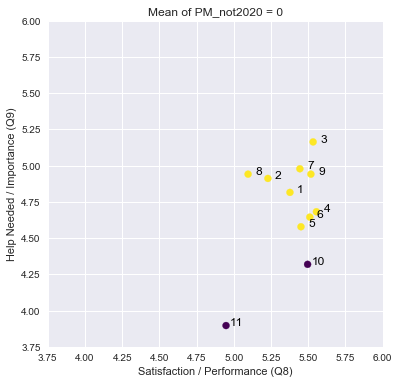

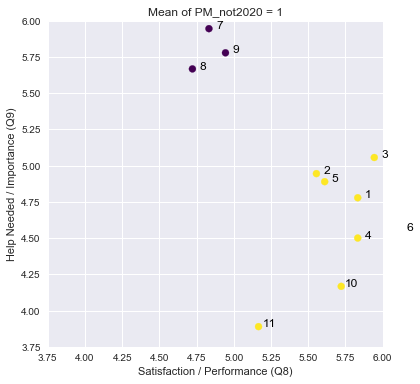

In [125]:
# Plot performance (Q8) vs. importance (Q9) for 11 items by PM_non2020
cross_analysis_1d(Q8, Q9, segment= df['PM_not2020'], n_cluster= 2, lim= (3.75, 6))

# PM_non2020 have a prioritized importance (key finding)

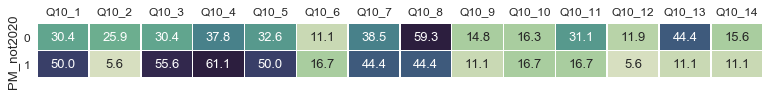

In [126]:
# Q10 proportion by PM_not2020
groupby_pct(Q10, segment= df['PM_not2020'], figsize= (13,1))

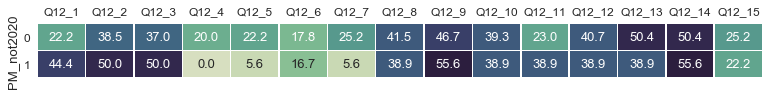

In [127]:
# Q12 proportion by PM_not2020
groupby_pct(Q12, segment= df['PM_not2020'], figsize= (13,1))

In [128]:
# Q1417 by PM_not2020
Q1417.groupby(df['PM_not2020']).agg(['mean', 'std', 'count']).round(3)

Q14_1               Q14_2                 Q15                 Q17  \
             mean    std count   mean    std count   mean    std count   mean   
PM_not2020                                                                      
0           5.630  1.091   135  5.281  1.077   135  5.563  1.444   135  3.511   
1           5.889  0.963    18  5.833  1.150    18  6.222  1.060    18  3.278   

                         
              std count  
PM_not2020               
0           2.022   135  
1           2.024    18

# International Students Analysis

In [129]:
# Create a dummy variable to separate international cohort
df['is_intl']= (df['intl'] == 'international').astype(int)

In [130]:
# T-test for intl. vs. non-intl. on overall satisfaction
multi_ttest_1d(df, 'is_intl', 'Q7', alpha= 0.05, violinplot= None)

# No difference

In Q7, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q7 when (is_intl = 0): 5.495, N: 97
mean of Q7 when (is_intl = 1): 5.375, N: 56
p-value of the difference: 0.458


In [131]:
# T-test for intl. vs. non-intl. on Q8 factors
Q8_cluster2['is_intl']= df['is_intl']
multi_ttest_2d(Q8_cluster2, 'is_intl', ['Q8_factor1', 'Q8_factor2', 'Q8_factor3'], alpha= 0.05, violinplot= None)

# No difference

In Q8_factor1, segments 0 vs. 1: the difference is statistically significant (reject H0)
mean of Q8_factor1 when (is_intl = 0): -0.129, N: 97
mean of Q8_factor1 when (is_intl = 1): 0.224, N: 56
p-value of the difference: 0.035
In Q8_factor2, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q8_factor2 when (is_intl = 0): 0.101, N: 97
mean of Q8_factor2 when (is_intl = 1): -0.175, N: 56
p-value of the difference: 0.101
In Q8_factor3, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q8_factor3 when (is_intl = 0): -0.069, N: 97
mean of Q8_factor3 when (is_intl = 1): 0.120, N: 56
p-value of the difference: 0.264


In [132]:
# T-test for intl. vs. non-intl. on importance (Q9)
multi_ttest_2d(df, 'is_intl', Q9.columns.values, alpha= 0.05, violinplot= None)

# No difference

In Q9_1, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q9_1 when (is_intl = 0): 4.948, N: 97
mean of Q9_1 when (is_intl = 1): 4.571, N: 56
p-value of the difference: 0.144
In Q9_2, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q9_2 when (is_intl = 0): 4.887, N: 97
mean of Q9_2 when (is_intl = 1): 4.964, N: 56
p-value of the difference: 0.759
In Q9_3, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q9_3 when (is_intl = 0): 5.165, N: 97
mean of Q9_3 when (is_intl = 1): 5.125, N: 56
p-value of the difference: 0.875
In Q9_4, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q9_4 when (is_intl = 0): 4.629, N: 97
mean of Q9_4 when (is_intl = 1): 4.714, N: 56
p-value of the difference: 0.738
In Q9_5, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q9_5 when (is_intl = 0): 4.629, N: 97
mean of Q9_5 when (is_intl = 1): 4.589, N: 56
p-value of the difference: 0.875
In Q9_6, segments 0 vs. 1: the difference is statistically significant

# AMBA Analysis

In [133]:
# Create a dummy variable
df['AMBA']= (df['program'] == 'AMBA').astype(int)

In [134]:
# Fisher's exact test with Q8_segment2
# Use Fisher's test here because the sample size is small
table, results= rp.crosstab(df['Q8_segment2'], df['AMBA'], test= 'fisher')
results

,Fisher's exact test,results
0,Odds ratio =,0.9284
1,2 sided p-value =,1.0000
2,Left tail p-value =,0.5098
3,Right tail p-value =,0.6550
4,Cramer's phi =,0.0142


In [135]:
# T-test on Q7 (overall satisfaction) 
multi_ttest_1d(df, 'AMBA', 'Q7', alpha= 0.05, violinplot= None)

In Q7, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q7 when (AMBA = 0): 5.463, N: 123
mean of Q7 when (AMBA = 1): 5.400, N: 30
p-value of the difference: 0.747


In [136]:
# T-test on Q8 (satisfaction)
multi_ttest_2d(df, 'AMBA', Q8_clusters, alpha= 0.05, violinplot= None)

In Q8_factor1, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q8_factor1 when (AMBA = 0): -0.044, N: 123
mean of Q8_factor1 when (AMBA = 1): 0.181, N: 30
p-value of the difference: 0.272
In Q8_factor2, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q8_factor2 when (AMBA = 0): 0.020, N: 123
mean of Q8_factor2 when (AMBA = 1): -0.082, N: 30
p-value of the difference: 0.621
In Q8_factor3, segments 0 vs. 1: no difference (fail to reject H0)
mean of Q8_factor3 when (AMBA = 0): 0.004, N: 123
mean of Q8_factor3 when (AMBA = 1): -0.018, N: 30
p-value of the difference: 0.914
